In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader

In [143]:
# 下载数据
olivetti_faces = fetch_olivetti_faces(data_home='./olivetti', shuffle=True)
# print(olivetti_faces.data.shape)
# print(olivetti_faces.target.shape)
# print(olivetti_faces.images.shape)

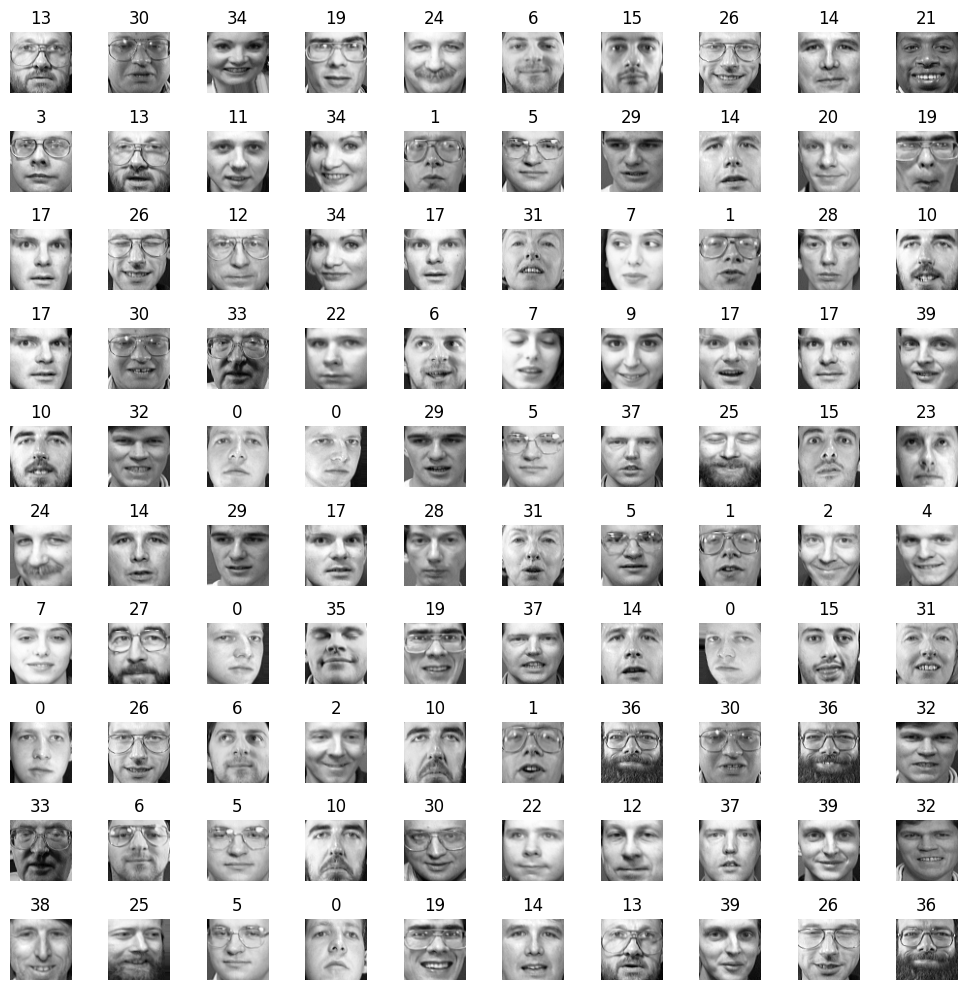

In [161]:
# 查看数据，40个target（人脸），每人10个
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
index = 1
for i in range(0,100,1):
    plt.subplot(10, 10, index)
    index += 1
    plt.imshow(olivetti_faces.images[i], cmap='gray')
    plt.title(f"{olivetti_faces.target[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [145]:
# 引入模型
# from olivettiface_model import olivettiface_model
# model1 = olivettiface_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Linear(4096, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 40)
).to(device)

In [146]:
# 超参数
LR = 1e-3
EPOCHS = 150
# BATCH_SIZE = 10 总共就400个数据，不用Dataloader

In [147]:
#损失函数
loss_fn = nn.CrossEntropyLoss()
#优化器
# sgd = optim.SGD(params=model.parameters(),lr=LR)    #原始sgd
# sgd_monment = optim.SGD(params=model.parameters(),lr=LR,momentum=0.5,weight_decay=1e-4)   #加入动量、权重衰减
# adam = optim.Adam(params=model.parameters(),lr=LR,weight_decay=1e-4)
# adamW = optim.AdamW(params=model.parameters(),lr=LR,weight_decay=1e-4)

In [148]:
origin_input = torch.tensor(olivetti_faces.data)
trarin_data = origin_input[:300] 
test_data = origin_input[300:400]
target = torch.tensor(olivetti_faces.target).long()


In [149]:
def train(epoches, model, input, target, loss_fn, optimizer_order):
    loss_his = []
    #优化器
    sgd = optim.SGD(params=model.parameters(),lr=LR)    #原始sgd
    sgd_monment = optim.SGD(params=model.parameters(),lr=LR,momentum=0.5,weight_decay=1e-4)   #加入动量、权重衰减
    adam = optim.Adam(params=model.parameters(),lr=LR,weight_decay=1e-4)
    adamW = optim.AdamW(params=model.parameters(),lr=LR,weight_decay=1e-4)
    if optimizer_order == 1:
        optimizer = sgd
    elif optimizer_order == 2:
        optimizer = sgd_monment
    elif optimizer_order == 3:
        optimizer = adam
    elif optimizer_order == 4:
        optimizer = adamW
    for i in range(epoches):
        output = model(input)
        loss = loss_fn(output, target)
        loss_his.append(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_his

In [150]:
#创建4个相同的model
models = nn.ModuleList([model for _ in range(4)])

In [151]:
train_hists = [train(epoches=EPOCHS, model=m, input=trarin_data.to(device), target=target[:300].to(device), loss_fn=loss_fn, optimizer_order=order)
               for m,order in zip(models,[1,2,3,4])]

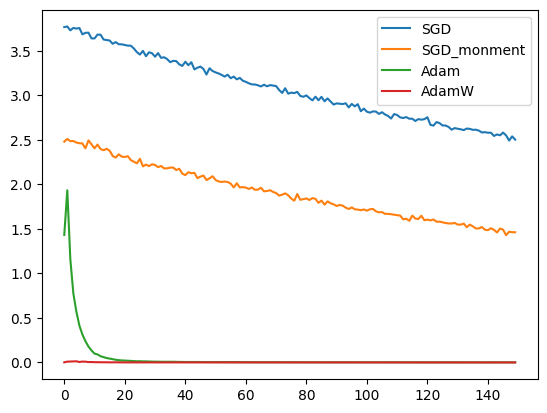

[3.765622854232788, 3.772197723388672, 3.7286951541900635, 3.755892753601074, 3.7484707832336426, 3.7548141479492188, 3.6838879585266113, 3.7010905742645264, 3.7026805877685547, 3.638375759124756, 3.6377575397491455, 3.6814706325531006, 3.679365634918213, 3.6254236698150635, 3.619948387145996, 3.6145389080047607, 3.577817440032959, 3.5965263843536377, 3.5729691982269287, 3.571674346923828, 3.564218759536743, 3.557210683822632, 3.5565457344055176, 3.524937629699707, 3.484128475189209, 3.4566667079925537, 3.498120069503784, 3.4382927417755127, 3.4827845096588135, 3.4715259075164795, 3.433035135269165, 3.4734089374542236, 3.4197123050689697, 3.4268078804016113, 3.406043767929077, 3.3715875148773193, 3.386455774307251, 3.3833489418029785, 3.346788167953491, 3.329313039779663, 3.37650990486145, 3.337441921234131, 3.370777130126953, 3.2902634143829346, 3.3092331886291504, 3.321626663208008, 3.2946548461914062, 3.232806921005249, 3.30309796333313, 3.272360324859619, 3.2567269802093506, 3.2449

In [152]:

import matplotlib.pyplot as plt
import numpy as np
plot_y = np.arange(0,EPOCHS,1)
plt.plot(plot_y, train_hists[0], label='SGD')
plt.plot(plot_y, train_hists[1], label='SGD_monment')
plt.plot(plot_y, train_hists[2], label='Adam')
plt.plot(plot_y, train_hists[3], label='AdamW')
plt.legend()
plt.show()

print(train_hists[0])
print(train_hists[1])
print(train_hists[2])
print(train_hists[3])

In [153]:
#准确率
def test(model, input, target):
    with torch.no_grad():
        output = model(input)
        _,predicted = torch.max(output,1)
        correct = (predicted==target).sum().item()
        rate = correct/target.size(0)
        print(f'predicted={predicted}\ntarget={target}\nrate={rate}')
        return rate

In [159]:
test(models[0], test_data, target[300:400])
test(models[1], test_data, target[300:400])
test(models[2], test_data, target[300:400])
test(models[3], test_data, target[300:400])

predicted=tensor([20, 33,  9, 38, 17, 22,  9, 36,  9, 35, 16,  6, 30,  4, 20, 27, 22, 14,
        14, 18, 13, 35, 39, 26, 32, 20,  8, 12, 34, 36,  9,  8, 26, 11, 29,  5,
        32, 25, 35,  4, 10, 36, 27, 35,  3,  5, 34, 12, 29,  2, 18, 16, 15, 24,
        20,  3,  3, 12, 18, 37, 28, 36, 14, 28, 37, 17,  7, 33, 33, 19, 24, 11,
        26,  7, 33, 25, 16, 33, 38, 17, 38,  3, 19, 31,  8,  7,  8, 29, 24, 27,
        21,  0, 35, 23, 25, 32, 19, 11,  4, 17])
target=tensor([20, 33,  9, 38, 17, 25,  9, 36,  9, 35, 16,  6, 30,  4, 20, 27, 22, 14,
        14, 18, 13, 35, 39, 26, 32, 20,  8, 12, 34, 36,  9,  8, 26, 11, 29,  5,
        32, 25, 35,  4, 10, 36, 27, 35,  3,  5, 34, 12, 29,  2, 18, 16, 15, 24,
        20,  3,  3, 12, 18, 37, 28, 36, 14, 28, 37, 17,  9, 33, 33, 19, 24, 11,
        26,  7, 33,  2, 16, 33, 38, 17, 38,  3, 19, 31,  8,  7,  8, 29, 24, 27,
        21,  0, 35, 19, 25, 32, 19, 11,  4, 17])
rate=0.96
predicted=tensor([20, 33,  9, 38, 17, 22,  9, 36,  9, 35, 16,  6, 30,  4, 2

0.95